# **Sales and Demand Forecasting**

## **Setup**

In [1]:
import pandas as pd
import numpy as np
from random import gauss, shuffle
import os, warnings, gc, copy, itertools, subprocess, shutil, sys, traceback
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import lightgbm as lgb
from gensim.models import Word2Vec # requires scipy<1.3 due to deprecation of lin. alg. funcs.

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Setup
data = 'data/'

class CFG:
    img_dim1 = 10
    img_dim2 = 6
    fontsize = 8
    marker = 1.5
    lines = 1.3

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})   

In [3]:
# Func to calculate RMSE
def rmse(x, y):
    return (np.round(np.sqrt(mse(x, y)), 4))

In [4]:
# Get data from kaggle
from pathlib import Path
import zipfile
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path, comp_check=True):
    os.makedirs(path, exist_ok=True)
    if any(Path(path).glob("*.zip")) or any(Path(path).iterdir()):
        print(f"Files already exist in '{path}'. Skipping download.")
        return
    if comp_check: kaggle_call = f"kaggle competitions download -c {dataset} -p {path}"
    else         : kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    for file in Path(path).glob("*.zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f"Extracted {file}")
        file.unlink()
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

In [5]:
# Modified clean memory function
def clean_ipython_hist():
    if not 'get_ipython' in globals(): return
    ip = get_ipython() # Current IPython instance
    user_ns = ip.user_ns # Namespace dictionary to store user variables
    pc = ip.displayhook.prompt_count + 1 # No. of commands executed in current session

    # Cycle through inputs in the namespace and clear the stored input history
    # 'None' ensures no error is raised if a key doesn't exist 
    for n in range(1, pc): user_ns.pop('_i' + repr(n), None)
    # Set the last 3 inputs in the session to clear references
    user_ns.update(dict(_i='', _ii='', _iii=''))
    # Call history manager
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc # Clear parsed input history
    hm.input_hist_raw[:] = [''] * pc # Clear raw input history
    hm._i = hm._ii = hm._i00 = '' # Clear inputs from hm

def clean_tb(): # Func to clear tracebacks
    if hasattr(sys, 'last_traceback'): # Check for last traceback
        traceback.clear_frames(sys.last_traceback) # Remove ref. to local vars
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type') # Remove last excep. type
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value') # Remove last excep. value

def clean_mem(): # Run mem cleaning operations
    clean_tb()
    clean_ipython_hist()
    gc.collect()


In [6]:
# Download M5 data
dataset = "m5-forecasting-accuracy"
download_path = "data/sales-forecasting/m5/"

download_data(dataset, download_path)

Files already exist in 'data/sales-forecasting/m5/'. Skipping download.


In [7]:
# Download secondary data
dataset = "konradb/partial-visuelle"
download_path = "data/sales-forecasting/partial-visuelle/"

download_data(dataset, download_path, comp_check=False)

Files already exist in 'data/sales-forecasting/partial-visuelle/'. Skipping download.


## **Data**

We will be working with data from the M5 competition titled ["M5 Forecasting Accuracy"](https://www.kaggle.com/c/m5-forecasting-accuracy).

>  The contest used a hierarchical sales data from Walmart to forecast daily sales for the next 28 days. From the comp description page: "The data covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events".

In [8]:
# Load data from one state and format 
xdat = pd.read_csv('data/sales-forecasting/m5/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


We need to be able to optimize how data is processed and modified in the parent dataframe in order to reduce memory usage.

In [9]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of the dataframe is {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not pd.api.types.is_categorical_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int16)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is {end_mem:.2f} MB')
    print(f'Memory usage decreased by {((start_mem - end_mem) / start_mem)*100:.2f}%')
    return df

In [10]:
xdat = reduce_mem_usage(xdat)

Memory usage of the dataframe is 178.65 MB
Memory usage after optimization is 35.74 MB
Memory usage decreased by 79.99%


In [11]:
# Melt data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
               var_name='d', value_name='sales').dropna()

In [12]:
xdat.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [13]:
xdat.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
23330943,FOODS_3_823_CA_4_validation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1913,0
23330944,FOODS_3_824_CA_4_validation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1913,1
23330945,FOODS_3_825_CA_4_validation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1913,0
23330946,FOODS_3_826_CA_4_validation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1913,4
23330947,FOODS_3_827_CA_4_validation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,d_1913,8


In [14]:
# Get proper timestamps
xcal = pd.read_csv('data/sales-forecasting/m5/calendar.csv')
# merge with primary
xdat = pd.merge(xdat, xcal, on='d', how='left')
# get rid of calendar data
del xcal

In [15]:
xdat.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [16]:
to_drop = ['d', 'wm_yr_wk', 'weekday', 'month', 'year', 'event_name_1', 'event_type_1',
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id']
xdat.drop(to_drop, axis=1, inplace=True)

xdat.head()

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


## **The Croston Model**

### The Basic Croston

A simple approach to predicting intermittent demand series is the Croston model, can be broken down into three steps:

- Evaluate the average demand level when there is a demand occurrence
- Evaluate the average time between two demand occurrences
- Forecast the demand as the demand level (when there is an occurrence) multiplied by the probability of having an occurrence.

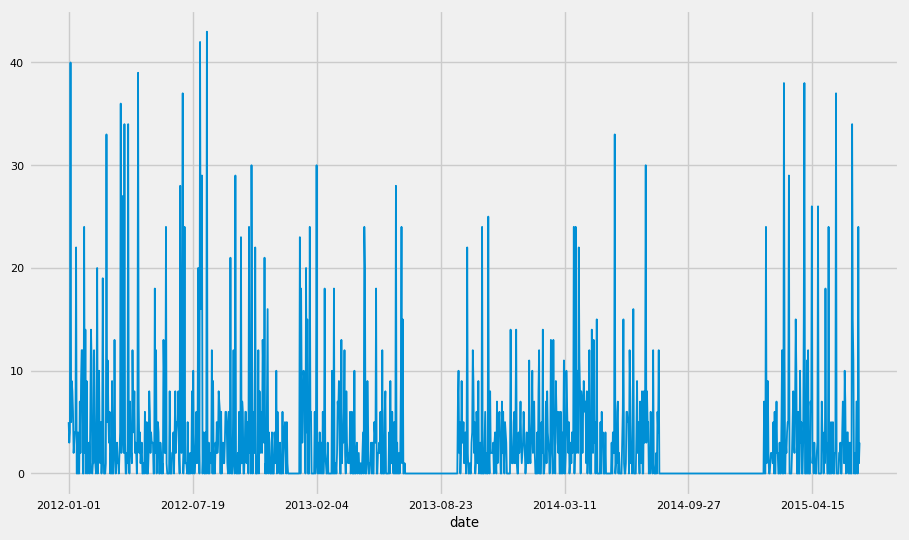

In [17]:
# Create a subset for single store and product combination
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1')][['date', 'sales']].copy()
df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]
df.set_index('date').sales.plot();

The code for the basic Croston and the TSB variant is taken from:

- [Nicolas Vandeput's medium post **"Forecasting Intermittent Demand with the Croston Model"**](https://medium.com/towards-data-science/croston-forecast-model-for-intermittent-demand-360287a17f5f)

In [18]:
def Croston(ts, extra_periods=1, alpha=0.4):
    d = np.array(ts) #Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods)# Append np.nan into the demand array to cover future periods
    
    # Level (a), Periodicity(p) and Forecast(f)
    a, p, f = np.full((3, cols+extra_periods), np.nan)
    q = 1 # Periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols] > 0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0] / p[0]
    # Create t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1] / p[t+1]
            q = 1
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
    # Future forecasts 
    a[cols+1 : cols+extra_periods] = a[cols]
    p[cols+1 : cols+extra_periods] = p[cols]
    f[cols+1 : cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Period": p, "Level": a, "Error": d-f})
    return df

In [19]:
# Generate a forecast with the algo above
pred_croston = Croston(df.sales, extra_periods=10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [20]:
pred_croston.describe()

,Demand,Forecast,Period,Level,Error
count,1277.000000,1287.000000,1287.000000,1287.000000,1277.000000
mean,3.436179,4.631322,1.868924,6.790804,-1.191861
std,6.246256,2.707730,3.777975,3.304883,6.857931
min,0.000000,0.104706,1.000000,1.671525,-22.261815
25%,0.000000,2.906772,1.210377,4.325927,-5.086734
50%,1.000000,4.036516,1.445201,6.801083,-2.889425
75%,4.000000,5.115665,1.827808,7.409026,0.470709
max,43.000000,22.261815,68.867120,24.280725,38.878650


In [21]:
pred_croston = pred_croston.Forecast.head(len(df))
print('RMSE: ' + str(rmse(df.sales, pred_croston)))

RMSE: 6.9581


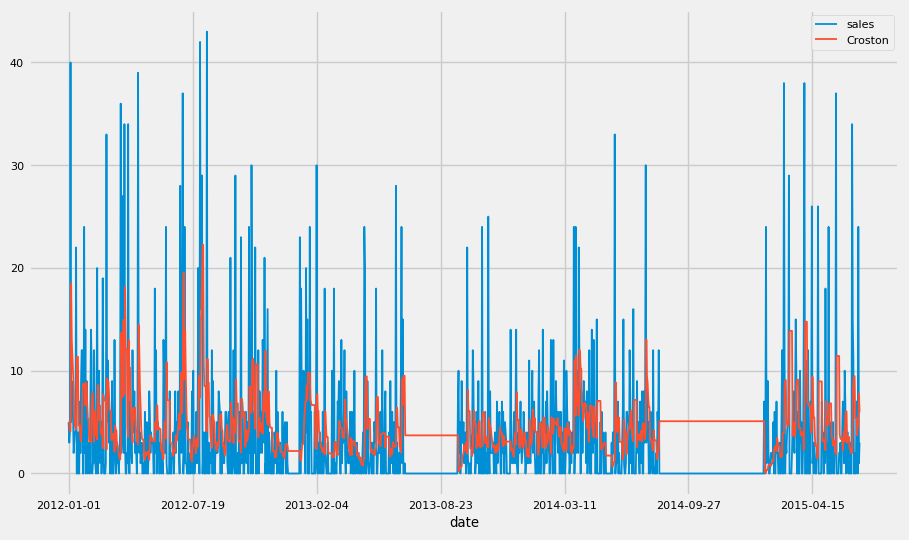

In [22]:
# Plot the forecast and actuals
df['Croston'] = pred_croston.values
df.set_index('date').plot();

The primary flaw with the basic form of the model is that forecasts are not updated during periods of no demand. So, in essence:
- extended periods with no demand ought to lead to a reduced forecast going forward.
- surges in demand after long periods of inactivity will not be captured accurately.

This model was improved in a 2011 publication titled ["Intermittent demand: Linking forecasting to inventory obsolescence"](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437), where a the model was allowed to decrease the periodicity estimate, even in the absence of demand.

Two key caveats are:

- the forecast `f` is defined as the periodicity `p` multiplied by the level `a` (and not divided by it, as in the original model)
- the forecast for `t+1` is defined based on the level and periodicity estimates of `t+1` (and not `t`).


In [23]:
def Croston_TSB(ts, extra_periods=1, alpha=0.4, beta=0.1):
    d = np.array(ts) #Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods)# Append np.nan into the demand array to cover future periods
    
    # Level (a), Periodicity(p) and Forecast(f)
    a, p, f = np.full((3, cols+extra_periods), np.nan)
    
    # Initialization
    first_occurence = np.argmax(d[:cols] > 0)
    a[0] = d[first_occurence]
    p[0] = 1 / (1+first_occurence)
    f[0] = a[0] * p[0] # Change from the original model
    # Create t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = beta*(1) + (1-beta)*p[t]
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]
        f[t+1] = p[t+1] * a[t+1]
    # Future forecasts 
    a[cols+1 : cols+extra_periods] = a[cols]
    p[cols+1 : cols+extra_periods] = p[cols]
    f[cols+1 : cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Period": p, "Level": a, "Error": d-f})
    return df

In [24]:
# Fitting the data to the augmented model
pred_croston_tsb = Croston_TSB(df.sales, extra_periods=10, alpha=0.1, beta=0.1)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE: ' + str(rmse(df.sales, pred_croston_tsb)))

RMSE: 6.1255


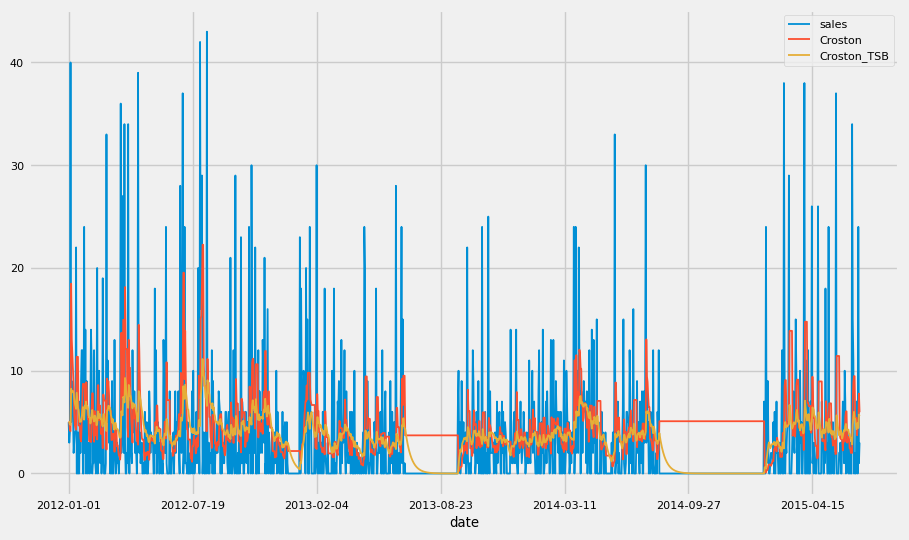

In [25]:
# Plotting results while comparing with original model
df['Croston_TSB'] = pred_croston_tsb.values
df.set_index('date').plot();

When compared to the vanilla model, the TSB version improves error handling to a marginal degree. It also solves the problem with forecast adjustments in zero sales periods.

While this model allows us to handle intermittent time series, it doesn;t have a natural extension to multivariate cases. So we need to move to more capable ML models.

## **Transitioning to Machine Learning**

Benchmarking any tabular data series using tree based models is a safe bet in movings towards robust forecasting solutions. Our time series problem can be formulated as a regression exercise and we can use LightGBM to predict the sales in multiple stores, while using the same data with additional augmentations / feature engineering.

In [26]:
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


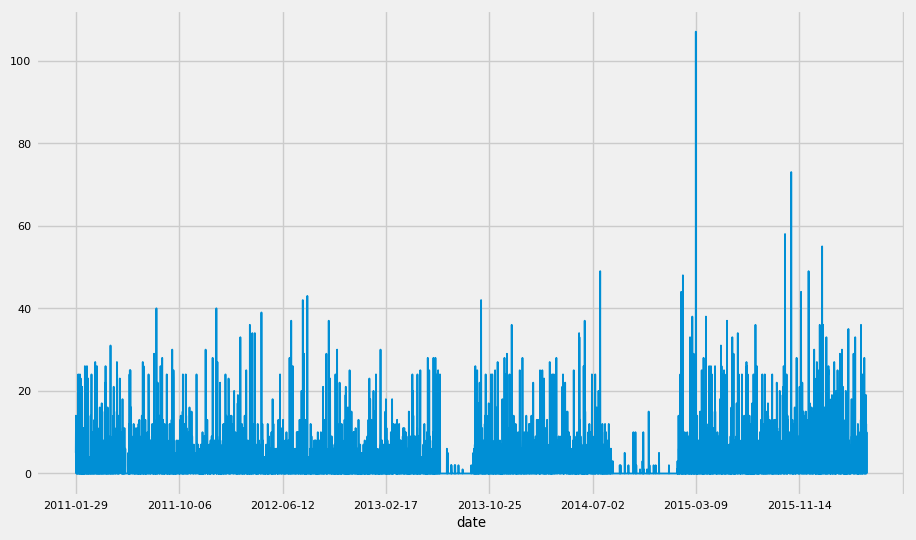

In [27]:
# Creating subset
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288'][['date', 'sales']].copy()
df.set_index('date').sales.plot();

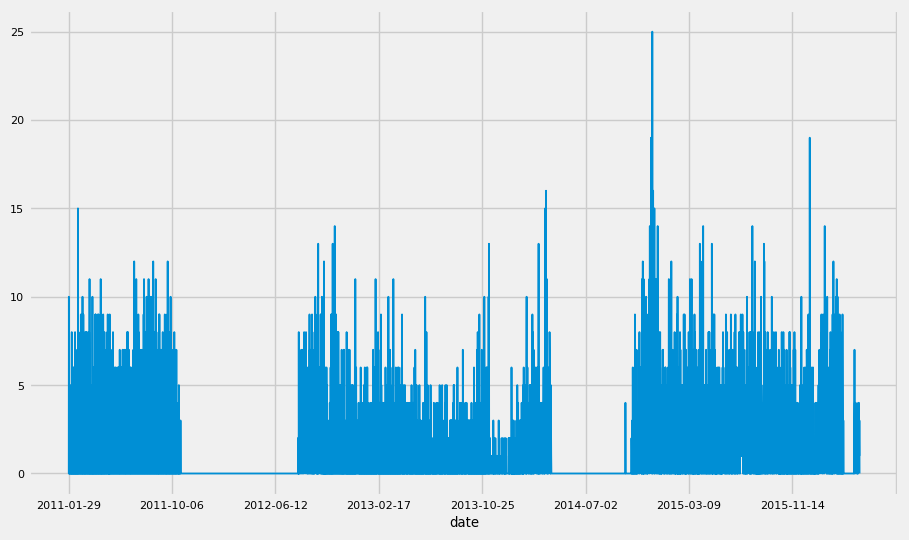

In [28]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot();

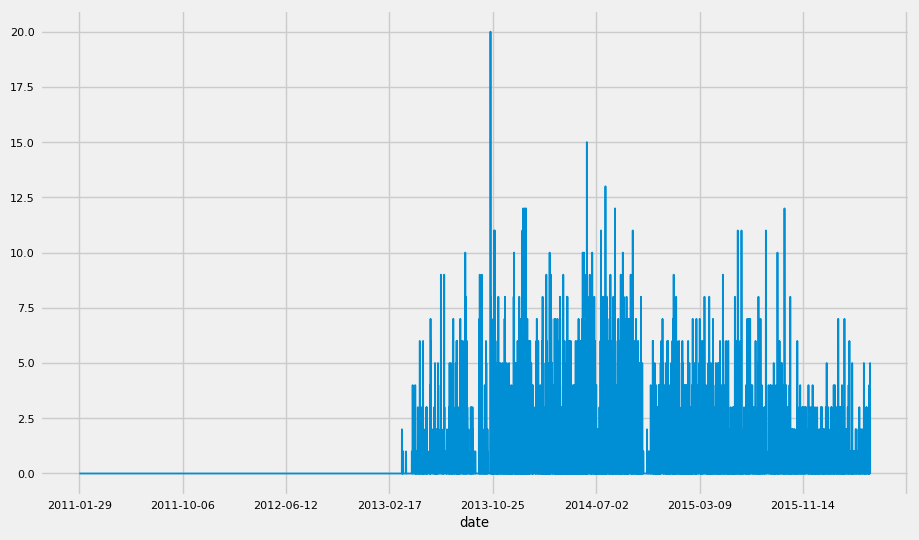

In [29]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot();

We will generate features to capture temporal dynamics while jointly modeling all the time series jointly.

In [30]:
# Creating lag features with simple moving averages over a given time period
# using shifted windows
def process_features(dt, lags=[28], wins=[7,28]):
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id", "sales"]].groupby("id")['sales'].shift(lag).fillna(-1)

    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col]\
                                                          .transform(lambda x: x.rolling(win).mean()).fillna(-1)
    return dt

In [31]:
xdat = process_features(xdat)

In [32]:
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0


In [33]:
# Now for time based features
xdat['date'] = pd.to_datetime(xdat["date"])

date_features = {
    "wday"   : "weekday",
    "week"   : "week",
    "month"  : "month",
    "quarter": "quarter",
    "year"   : "year",
    "mday"   : "day"
}

for feat_name, feat_func in date_features.items():
    if feat_name in xdat.columns:
        xdat[feat_name] = xdat[feat_name].astype("int16")
    else:
        if feat_name=="week":
            xdat[feat_name] = xdat["date"].dt.isocalendar().week.astype("int16")
        else:
            xdat[feat_name] = getattr(xdat["date"].dt, feat_func).astype("int16")

In [34]:
# Encoding categorical features
cat_feats = ['item_id', 'dept_id', 'store_id', 'cat_id']
for cc in cat_feats:
    le = LabelEncoder()
    xdat[cc] = le.fit_transform(xdat[cc])

In [35]:
xdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23330948 entries, 0 to 23330947
Data columns (total 15 columns):
 #   Column    Dtype         
---  ------    -----         
 0   id        category      
 1   item_id   int64         
 2   dept_id   int64         
 3   cat_id    int64         
 4   store_id  int64         
 5   sales     int16         
 6   date      datetime64[ns]
 7   wday      int16         
 8   snap_CA   int64         
 9   lag_28    float64       
 10  week      int16         
 11  month     int16         
 12  quarter   int16         
 13  year      int16         
 14  mday      int16         
dtypes: category(1), datetime64[ns](1), float64(1), int16(7), int64(5)
memory usage: 1.6 GB


In [36]:
# Split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit='D')
#xtrain = xdat.loc[xdat.date < cutoff].copy()
#xvalid = xdat.loc[xdat.date >= cutoff].copy()
xtrain = xdat[xdat.date < cutoff]

In [37]:
xvalid = xdat[xdat.date >= cutoff]

In [38]:
# Free up some more memory
del xdat

xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,week,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,2011-01-29,1,0,-1.0,4,1,1,2011,29
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,2011-01-29,1,0,-1.0,4,1,1,2011,29
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,2011-01-29,1,0,-1.0,4,1,1,2011,29


In [39]:
clean_mem()

In [40]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()

In [41]:
to_drop = ['id', 'wday', 'sales', 'snap_CA', 'year', 'date']
xtrain.drop(to_drop, axis=1, inplace=True)
xvalid.drop(to_drop, axis=1, inplace=True)

In [42]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22977264 entries, 0 to 22977263
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   item_id   int64  
 1   dept_id   int64  
 2   cat_id    int64  
 3   store_id  int64  
 4   lag_28    float64
 5   week      int16  
 6   month     int16  
 7   quarter   int16  
 8   mday      int16  
dtypes: float64(1), int16(4), int64(4)
memory usage: 1.2 GB


In [43]:
xtrain.to_feather('data/store_demand_xtrain.feather')
xvalid.to_feather('data/store_demand_xvalid.feather')
ytrain.to_csv('data/store_demand_ytrain.csv', index=False)
yvalid.to_csv('data/store_demand_yvalid.csv', index=False)

**`Load point due to persistent memory issues.`**

## **Reload Data (Following Kernel Restart)**

In [6]:
# Load from pickle
xtrain = pd.read_feather('data/store_data.feather')
xvalid = pd.read_feather('data/store_demand_xvalid.feather')
ytrain = pd.read_csv('data/store_demand_ytrain.csv')
yvalid = pd.read_csv('data/store_demand_yvalid.csv')

In [7]:
# Load data into LGBM data loaders
dtrain = lgb.Dataset(xtrain, label=ytrain, free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label=yvalid, free_raw_data=False)

In [8]:
# What can the probability masses tell us about the data
ytrain.describe()

,sales
count,2.297726e+07
mean,1.225128e+00
std,4.114048e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,7.630000e+02


In [9]:
# Fitting the model which allows for probability mass centered around single values
params = {
    "objective"       : "poisson",
    "metric"          : "rmse",
    "learning_rate"   : 0.075,
    "sub_feature"     : 0.8,
    "sub_row"         : 0.75,
    "bagging_freq"    : 1,
    "lambda_12"       : 0.1,
    "verbosity"       : 1,
    "num_iterations"  : 1000,
    "num_leaves"      : 128,
    "min_data_in_leaf": 50
}

model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid],
                  callbacks=[lgb.early_stopping(stopping_rounds=150)])

[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 9
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[556]	training's rmse: 2.80433	valid_1's rmse: 2.54814


--PROSE on DISTRIBUTIONS--

In [10]:
# Fitting the model which allows for probability mass centered around single values
params = {
    "objective"       : "tweedie",
    "metric"          : "rmse",
    "learning_rate"   : 0.075,
    "sub_feature"     : 0.8,
    "sub_row"         : 0.75,
    "bagging_freq"    : 1,
    "lambda_12"       : 0.1,
    "verbosity"       : 1,
    "num_iterations"  : 1000,
    "num_leaves"      : 128,
    "min_data_in_leaf": 50
}

model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid],
                  callbacks=[lgb.early_stopping(stopping_rounds=150),
                             lgb.log_evaluation(100)])

[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 9
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.89756	valid_1's rmse: 2.55987
[200]	training's rmse: 2.86643	valid_1's rmse: 2.55579
[300]	training's rmse: 2.84691	valid_1's rmse: 2.55116
[400]	training's rmse: 2.83701	valid_1's rmse: 2.55157
[500]	training's rmse: 2.82472	valid_1's rmse: 2.55208
Early 

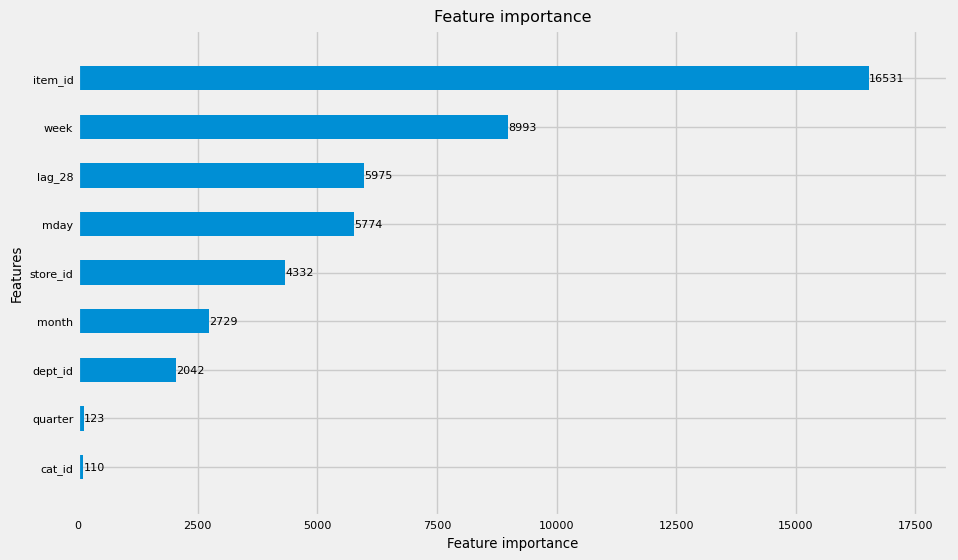

In [12]:
lgb.plot_importance(model, height=0.5);

**--Prose--**

## **Predicting Sales for New Products**

The prediction of sales for new / previously unreleased products is extremely challenging. This boils down to the sparsity or total lack of historical data and the highly dynamic nature of future trends.

The research community has been attempting to come up with viable solutions to this problem, an example of this can be found in the paper ["Well Googled is Half Done: Multimodal Forecasting of New Fashion Product Sales with Image-based Google Trends"](https://arxiv.org/abs/2109.09824). The abstract states:

>New fashion product sales forecasting is a challenging problem that involves many business dynamics and cannot be solved by classical forecasting approaches. In this paper, we investigate the effectiveness of systematically probing exogenous knowledge in the form of Google Trends time series and combining it with multi-modal information related to a brand-new fashion item, in order to effectively forecast its sales despite the lack of past data.
>
>In particular, we propose a neural network-based approach, **where an encoder learns a representation of the exogenous time series, while the decoder forecasts the sales based on the Google Trends encoding and the available visual and metadata information. Our model works in a non-autoregressive manner, avoiding the compounding effect of large first-step errors.** As a second contribution, we present VISUELLE, a publicly available dataset for the task of new fashion product sales forecasting, containing multimodal information for 5577 real, new products sold between 2016-2019 from Nunalie, an Italian fast-fashion company. The dataset is equipped with images of products, metadata, related sales, and associated Google Trends.
>
>We use VISUELLE to compare our approach against state-of-the-art alternatives and several baselines, showing that our neural network-based approach is the most accurate in terms of both percentage and absolute error. It is worth noting that the addition of exogenous knowledge boosts the forecasting accuracy by 1.5% in terms of Weighted Absolute Percentage Error (WAPE), revealing the importance of exploiting informative external information.

[Refer to the repo for the code and dataset.](https://github.com/HumaticsLAB/GTM-Transformer)

While this is certainly no silver bullet, it highlights the need for creativity in this space with a healthy respect for underlying rules of mathematics, statistics, probability and good old common sense!

In [8]:
xtrain = pd.read_csv('data/sales-forecasting/partial-visuelle/train.csv')
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,...,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem
3,0.000939,0.044131,0.046948,0.041315,0.028169,0.031925,0.031925,0.023474,0.016901,0.028169,...,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00004.png,yellow,acrylic,sleeveless
4,0.006573,0.098592,0.125822,0.120188,0.068545,0.046948,0.043192,0.034742,0.030047,0.029108,...,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00005.png,grey,acrylic,hem


In [9]:
xtest = pd.read_csv('data/sales-forecasting/partial-visuelle/test.csv')
xtest.head()

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.032864,0.062911,0.054460,0.056338,0.042254,0.033803,0.037559,0.029108,0.016901,0.012207,...,short sleeves,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05081.png,grey,georgette,hem
1,0.046948,0.060094,0.083568,0.117371,0.079812,0.089202,0.078873,0.061033,0.023474,0.015962,...,culottes,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05082.png,red,bengaline,strapless
2,0.043192,0.086385,0.079812,0.080751,0.061972,0.062911,0.054460,0.045070,0.021596,0.015962,...,kimono dress,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05083.png,white,frise,hem
3,0.060094,0.090141,0.076995,0.060094,0.041315,0.024413,0.018779,0.006573,0.002817,0.001878,...,long sleeve,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05084.png,grey,scuba crepe,hem
4,0.062911,0.108920,0.105164,0.116432,0.066667,0.059155,0.056338,0.076056,0.061033,0.053521,...,doll dress,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05085.png,grey,georgette,hem


In [10]:
xtrain.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'external_code', 'season', 'category', 'release_date', 'day', 'week',
       'month', 'year', 'image_path', 'color', 'fabric', 'extra'],
      dtype='object')

In [11]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5080 entries, 0 to 5079
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              5080 non-null   float64
 1   1              5080 non-null   float64
 2   2              5080 non-null   float64
 3   3              5080 non-null   float64
 4   4              5080 non-null   float64
 5   5              5080 non-null   float64
 6   6              5080 non-null   float64
 7   7              5080 non-null   float64
 8   8              5080 non-null   float64
 9   9              5080 non-null   float64
 10  10             5080 non-null   float64
 11  11             5080 non-null   float64
 12  external_code  5080 non-null   int64  
 13  season         5080 non-null   object 
 14  category       5080 non-null   object 
 15  release_date   5080 non-null   object 
 16  day            5080 non-null   float64
 17  week           5080 non-null   float64
 18  month   

In [15]:
xtrain.describe(include='object')

,season,category,release_date,image_path,color,fabric,extra
count,5080,5080,5080,5080,5080,5080,5080
unique,6,27,815,5080,10,58,23
top,AW18,long sleeve,2019-06-13,PE17/00001.png,grey,georgette,hem
freq,999,1109,39,1,1090,692,2968


In [16]:
xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,external_code,day,week,month,year
count,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000
mean,0.014884,0.051102,0.058264,0.056137,0.054268,0.053161,0.050315,0.046183,0.041616,0.037107,0.030973,0.027149,2540.500000,0.526575,0.499440,0.535105,0.999445
std,0.023272,0.050550,0.052228,0.050573,0.050793,0.054166,0.056004,0.057796,0.055524,0.055351,0.048515,0.048246,1466.614014,0.284090,0.282472,0.281798,0.000409
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,0.000000,0.000000,0.000000,-0.001878,-0.000939,0.000000,1.000000,0.000000,0.019231,0.083333,0.998514
25%,0.002817,0.017840,0.022535,0.021596,0.021596,0.019718,0.018779,0.015962,0.012207,0.009390,0.006573,0.004695,1270.750000,0.333333,0.230769,0.250000,0.999009
50%,0.006573,0.037559,0.044131,0.044131,0.041315,0.037559,0.033803,0.030047,0.025352,0.021596,0.016901,0.014085,2540.500000,0.500000,0.538462,0.583333,0.999505
75%,0.017840,0.066667,0.079812,0.074178,0.069484,0.067606,0.061033,0.053521,0.047887,0.043192,0.036620,0.030986,3810.250000,0.666667,0.730769,0.750000,1.000000
max,0.512676,0.763380,0.460094,0.596244,0.628169,0.739906,0.684507,0.998122,0.615962,1.000000,0.921127,0.905164,5080.000000,1.000000,1.000000,1.000000,1.000000


### **MultiOutput**

In [21]:
# Split into targets and variables which will be used for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols], xtest[target_cols]
x0, x1 = xtrain[cat_cols], xtest[cat_cols]

In [24]:
# Carry out tfms on categoricals
xdat = pd.concat([x0, x1], axis=0)
xdat = pd.get_dummies(xdat)
x0 = xdat.iloc[:x0.shape[0]]
x1 = xdat.iloc[x0.shape[0]:]
del xdat

In [26]:
# Fit the model
base_model = Ridge()
mo_base = MultiOutputRegressor(base_model, n_jobs=-1)

mo_base.fit(x0, y0)

mo_prediction = mo_base.predict(x1)

In [29]:
print('(loose) MSE: ' + str(np.round(np.sqrt(np.average((mo_prediction - y1)**2)), 4)))

(loose) MSE: 0.0508


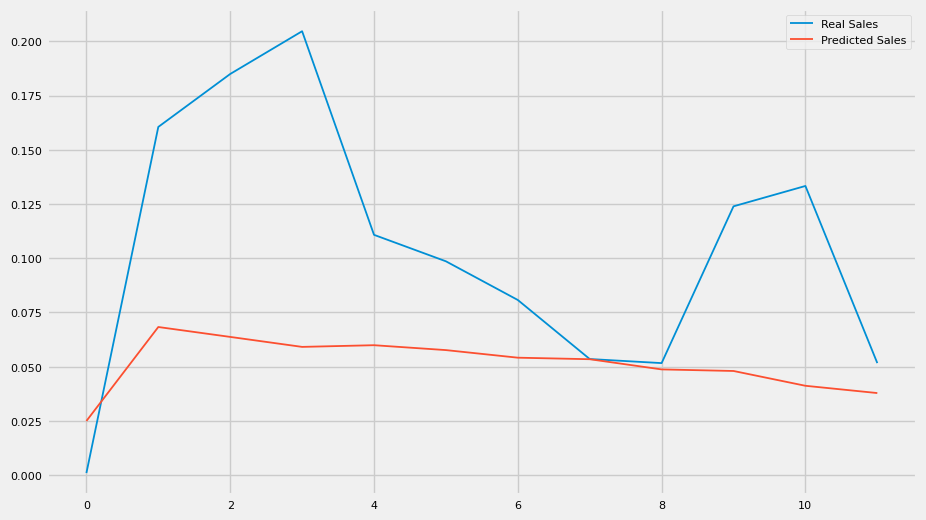

In [33]:
# Picking a few samples
ii = 5
plt.plot(y0.values[ii, :], label='Real Sales')
plt.plot(mo_prediction[ii, :], label='Predicted Sales')
plt.legend()
plt.show();

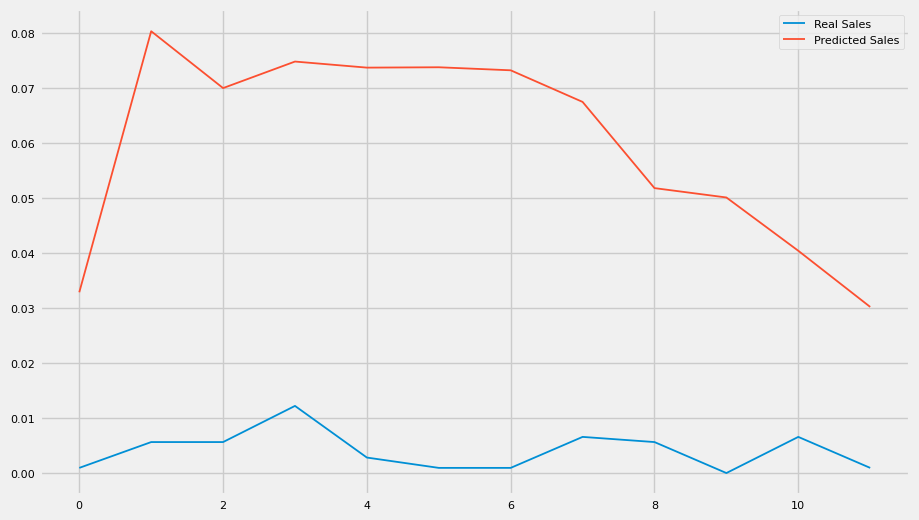

In [34]:
ii = 33
plt.plot(y0.values[ii, :], label='Real Sales')
plt.plot(mo_prediction[ii, :], label='Predicted Sales')
plt.legend()
plt.show();

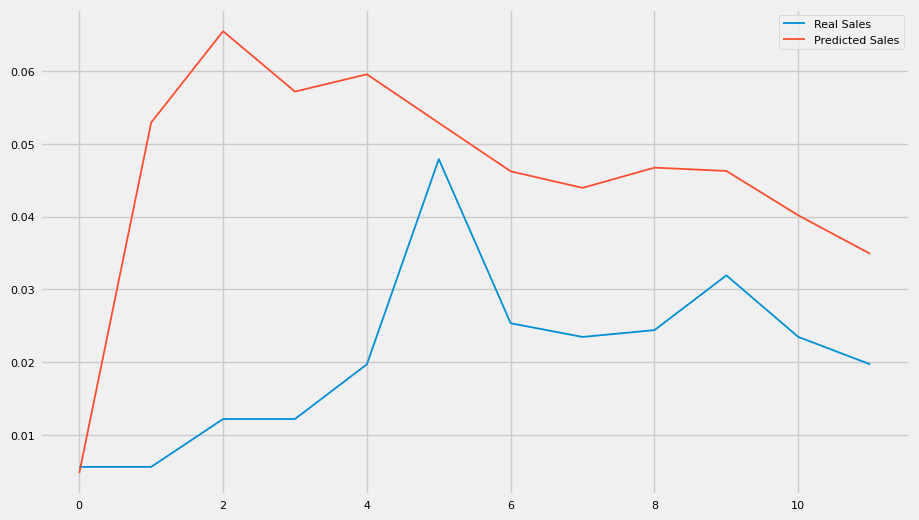

In [35]:
ii = 150
plt.plot(y0.values[ii, :], label='Real Sales')
plt.plot(mo_prediction[ii, :], label='Predicted Sales')
plt.legend()
plt.show();